In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd

## Testing the proportional hazard assumptions

This Jupyter notebook is a small tutorial on how to test and fix proportional hazard problems. An important question to first ask is: [_do I need to care about the proportional hazard assumption?_](#Do-I-need-to-care-about-the-proportional-hazard-assumption?) - often the answer is no. 

The proportional hazard assumption is that _all_ individuals have the same hazard function, but a unique scaling factor infront. So the _shape_ of the hazard function is the same for all individuals, and only a scalar multiple changes per individual. 

$$h_i(t) = a_i h(t)$$

At the core of the assumption is that $a_i$ is not time varying, that is, $a_i(t) = a_i$. Further more, if we take the ratio of this with another subject (called the hazard ratio): 

$$\frac{h_i(t)}{h_j(t)} = \frac{a_i h(t)}{a_j h(t)} = \frac{a_i}{a_j}$$

is constant for all $t$. In this tutorial we will test this non-time varying assumption, and look at ways to handle violations. 


In [2]:
# from lifelines.datasets import load_rossi
# rossi = load_rossi()
# read dataset
brain = pd.read_csv('./brain_cancer.csv')
brain

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...
83,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07


In [3]:
# convert categorical to dummy variables
brain_dummy = pd.get_dummies(brain, drop_first = True)
brain_dummy

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,90,6.11,0,57.64,0,0,1,0,0,0
1,90,19.35,1,8.98,1,0,0,0,1,1
2,70,7.95,0,26.46,0,0,1,0,0,0
3,80,7.61,1,47.80,0,1,0,0,1,1
4,90,5.06,1,6.30,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
83,80,0.16,1,20.69,1,0,0,0,1,1
84,80,19.81,1,6.39,1,0,0,0,1,1
85,90,2.50,0,32.82,1,0,1,0,1,1
86,90,2.02,0,42.07,1,0,1,0,1,0


In [4]:
# copy brain_dummy
brain_scaled = brain_dummy.copy()

# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# fit scaler only to 'ki' and 'gtv'
brain_scaled[['ki', 'gtv']] = scaler.fit_transform(brain_scaled[['ki', 'gtv']])
brain_scaled

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,0.833333,0.176148,0,57.64,0,0,1,0,0,0
1,0.833333,0.558475,1,8.98,1,0,0,0,1,1
2,0.500000,0.229281,0,26.46,0,0,1,0,0,0
3,0.666667,0.219463,1,47.80,0,1,0,0,1,1
4,0.833333,0.145827,1,6.30,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
83,0.666667,0.004332,1,20.69,1,0,0,0,1,1
84,0.666667,0.571759,1,6.39,1,0,0,0,1,1
85,0.833333,0.071903,0,32.82,1,0,1,0,1,1
86,0.833333,0.058042,0,42.07,1,0,1,0,1,0


In [5]:
# fit Cox Proportional Hazard model
cph = CoxPHFitter()

cph.fit(brain_scaled, 'time', 'status')

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>

In [6]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -118.412
         time fit was run = 2024-02-15 23:51:33 UTC
                    model = untransformed variables

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
ki                   -3.475      0.031      1.099           -5.629           -1.322                0.004                0.267
gtv                   1.248      3.484      0.783           -0.287            2.784                0.750               16.177
sex_Male              0.098      1.103      0.361           -0.609            0.805                0.544                2.236
diagnosis_LG glioma  -1.091      0.336      0.574           -2.216            0.034                0.109                1.034
diagnosis_Meningioma -2.082      0.125      0.454           -2.971           -1.193                0.051                0.303
diagnosis_Other      -1.236      0.291      0.626           -2.463           -0.009                0.085                0.991
loc_Supratentorial    0.376      1.456      0.698           -0.992            1.743                0.371                5.717
stereo_SRT            0.140      1.150      0.598           -1.032            1.312                0.356                3.713

                       cmp to      z       p   -log2(p)
covariate                                              
ki                      0.000 -3.163   0.002      9.321
gtv                     0.000  1.593   0.111      3.170
sex_Male                0.000  0.271   0.786      0.347
diagnosis_LG glioma     0.000 -1.901   0.057      4.126
diagnosis_Meningioma    0.000 -4.589 <0.0005     17.777
diagnosis_Other         0.000 -1.975   0.048      4.372
loc_Supratentorial      0.000  0.539   0.590      0.761
stereo_SRT              0.000  0.233   0.815      0.294
---
Concordance = 0.789
Partial AIC = 252.825
log-likelihood ratio test = 39.472 on 8 df
-log2(p) of ll-ratio test = 17.926

### Checking assumptions with `check_assumptions`

New to lifelines 0.16.0 is the `CoxPHFitter.check_assumptions` method. This method will compute statistics that check the proportional hazard assumption, produce plots to check assumptions, and more. Also included is an option to display advice to the console. Here's a breakdown of each information displayed:

 - Presented first are the results of a statistical test to test for any time-varying coefficients. A time-varying coefficient imply a covariate's influence _relative to the baseline_ changes over time. This implies a violation of the proportional hazard assumption. For each variable, we transform _time_ four times (these are common transformations of time to perform). If _lifelines_ rejects the null (that is, _lifelines_ rejects that the coefficient is not time-varying), we report this to the user.
 - Some advice is presented on how to correct the proportional hazard violation based on some summary statistics of the variable. 
 - As a compliment to the above statistical test, for each variable that violates the PH assumption, visual plots of the the _scaled Schoenfeld residuals_ is presented against the four time transformations. A fitted lowess is also presented, along with 10 bootstrapped lowess lines (as an approximation to the confidence interval of the original lowess line). Ideally, this lowess line is constant (flat). Deviations away from the constant line are violations of the PH assumption. 
 
####  Why the _scaled Schoenfeld residuals_?
 
This section can be skipped on first read. Let $s_{t,j}$ denote the scaled Schoenfeld residuals of variable $j$ at time $t$, $\hat{\beta_j}$ denote the maximum-likelihood estimate of the $j$th variable, and $\beta_j(t)$ a time-varying coefficient in (fictional) alternative model that allows for time-varying coefficients. Therneau and Grambsch showed that. 

$$E[s_{t,j}] + \hat{\beta_j} = \beta_j(t)$$

The proportional hazard assumption implies that $\hat{\beta_j} = \beta_j(t)$, hence $E[s_{t,j}] = 0$. This is what the above proportional hazard test is testing. Visually, plotting $s_{t,j}$ over time (or some transform of time), is a good way to see violations of $E[s_{t,j}] = 0$, along with the statisical test. 


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.7383)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8462)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4939)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5867)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3081)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2079)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5024)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3656)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7904)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6626)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3103)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4320)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5999)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4419)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4806)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5442)'>]]

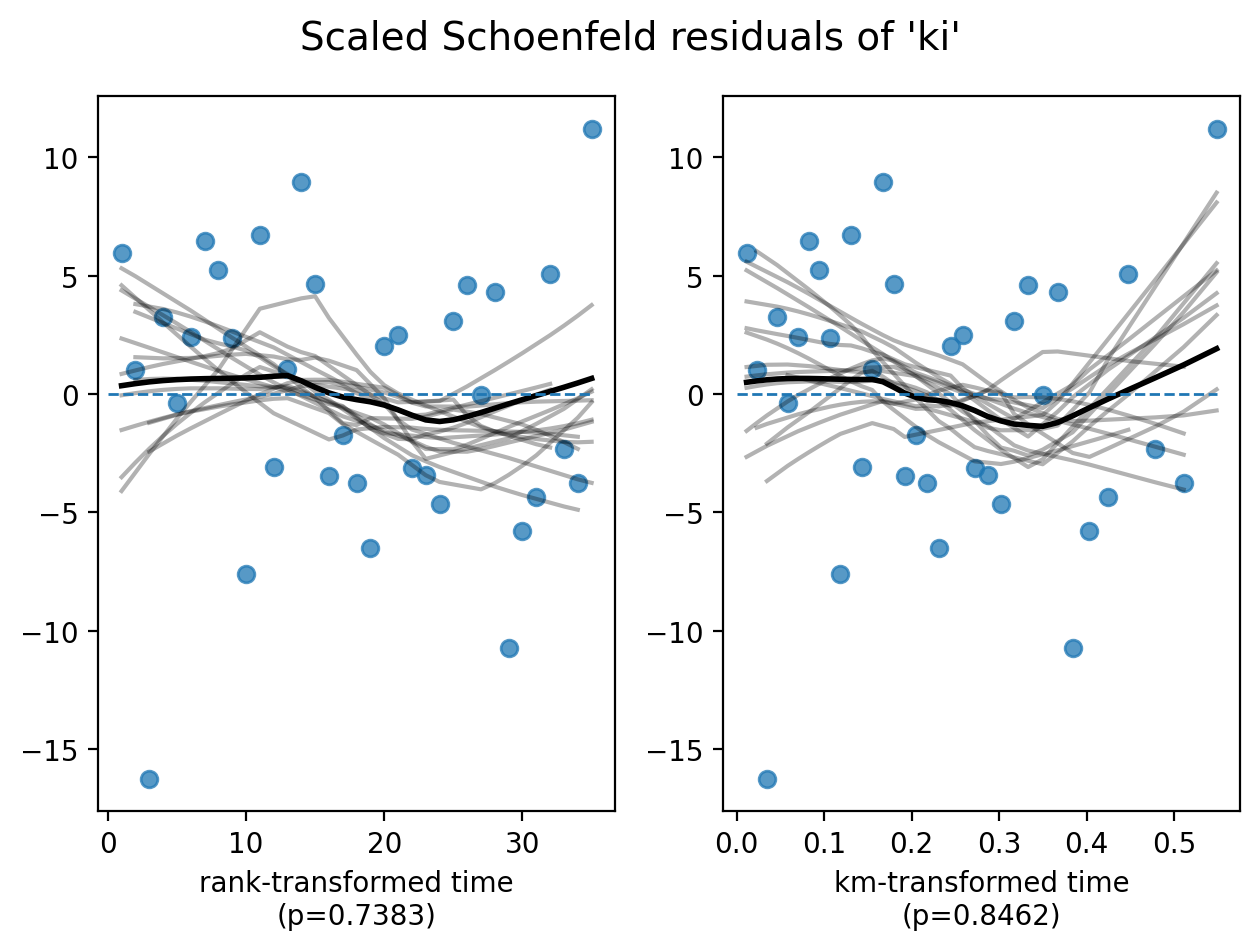

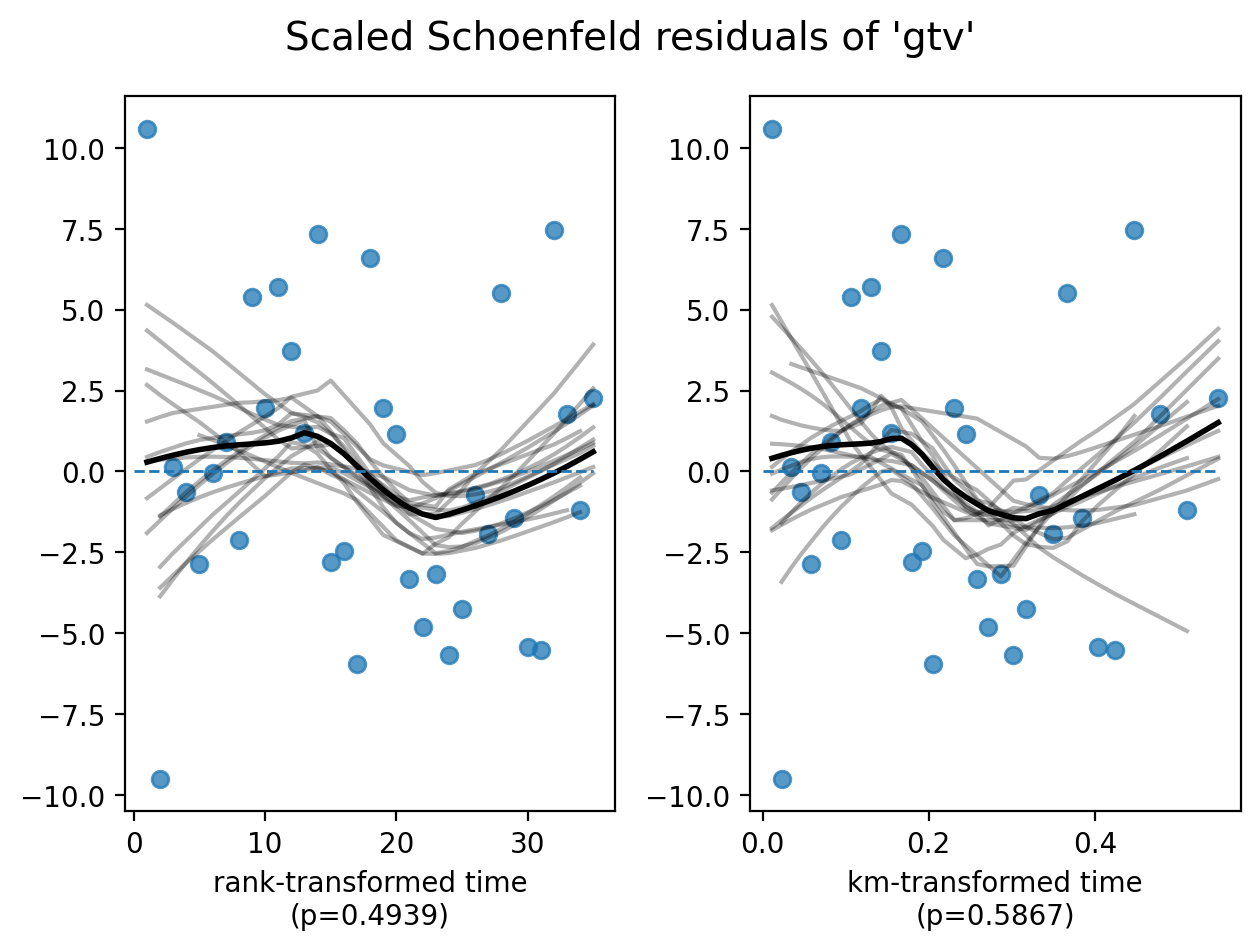

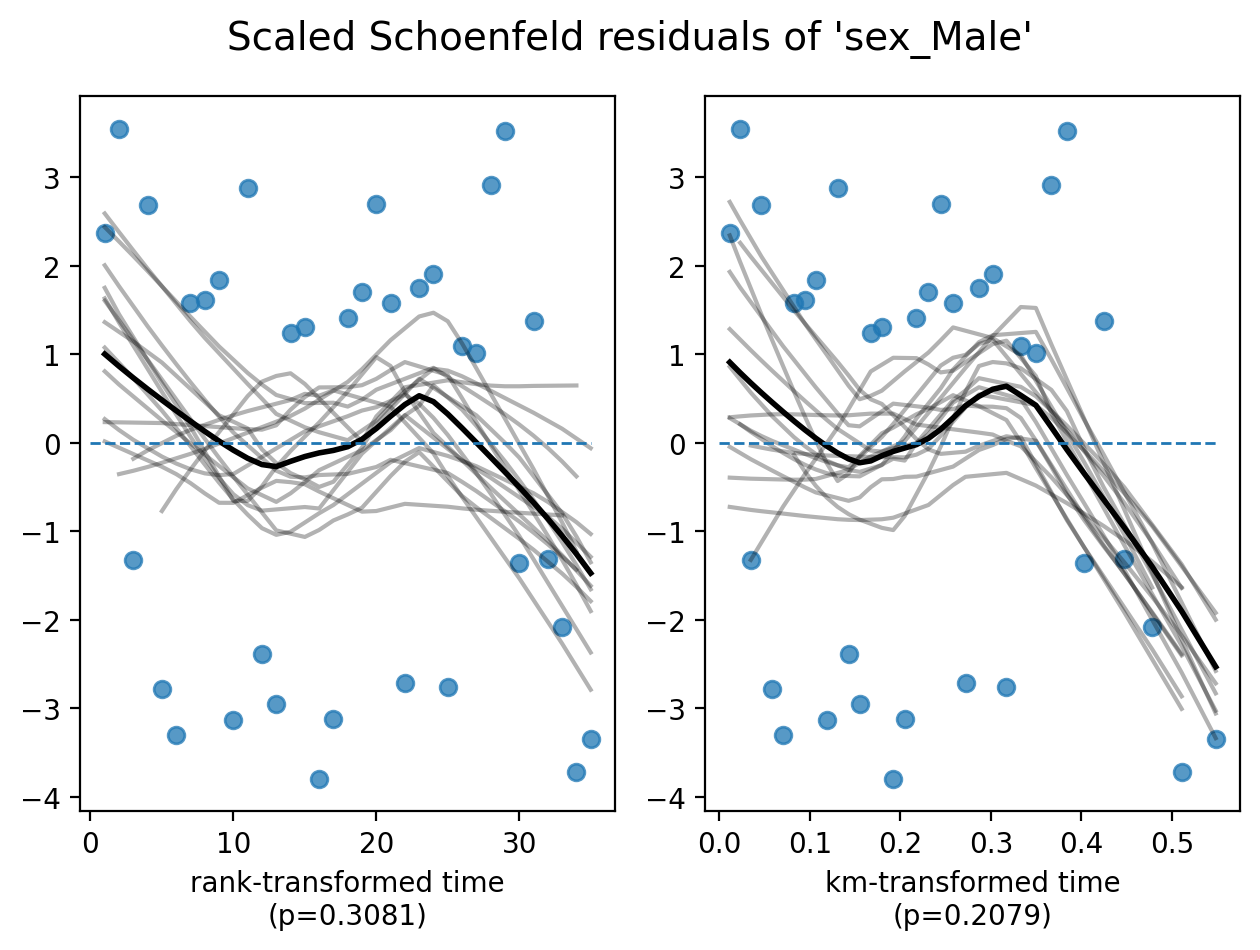

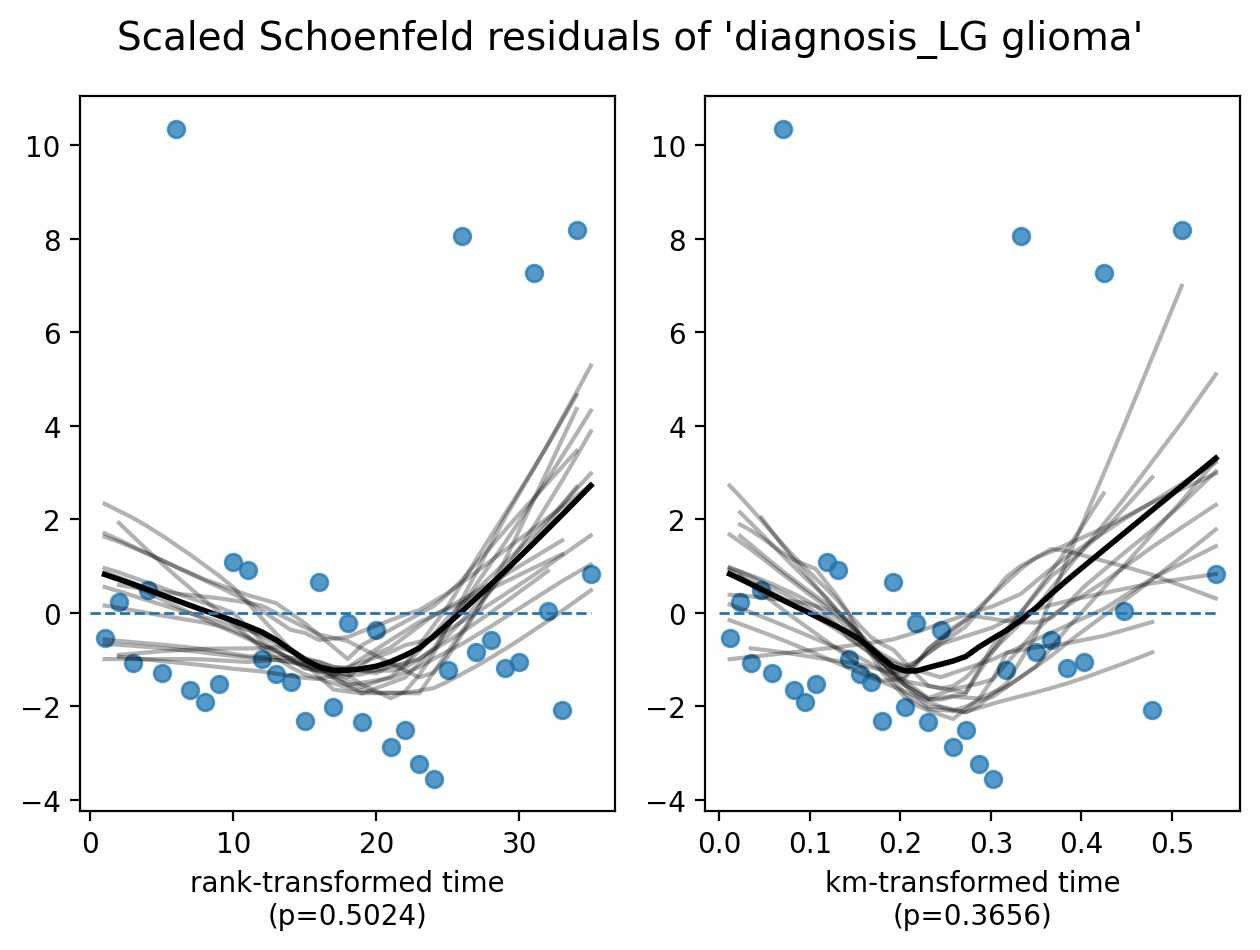

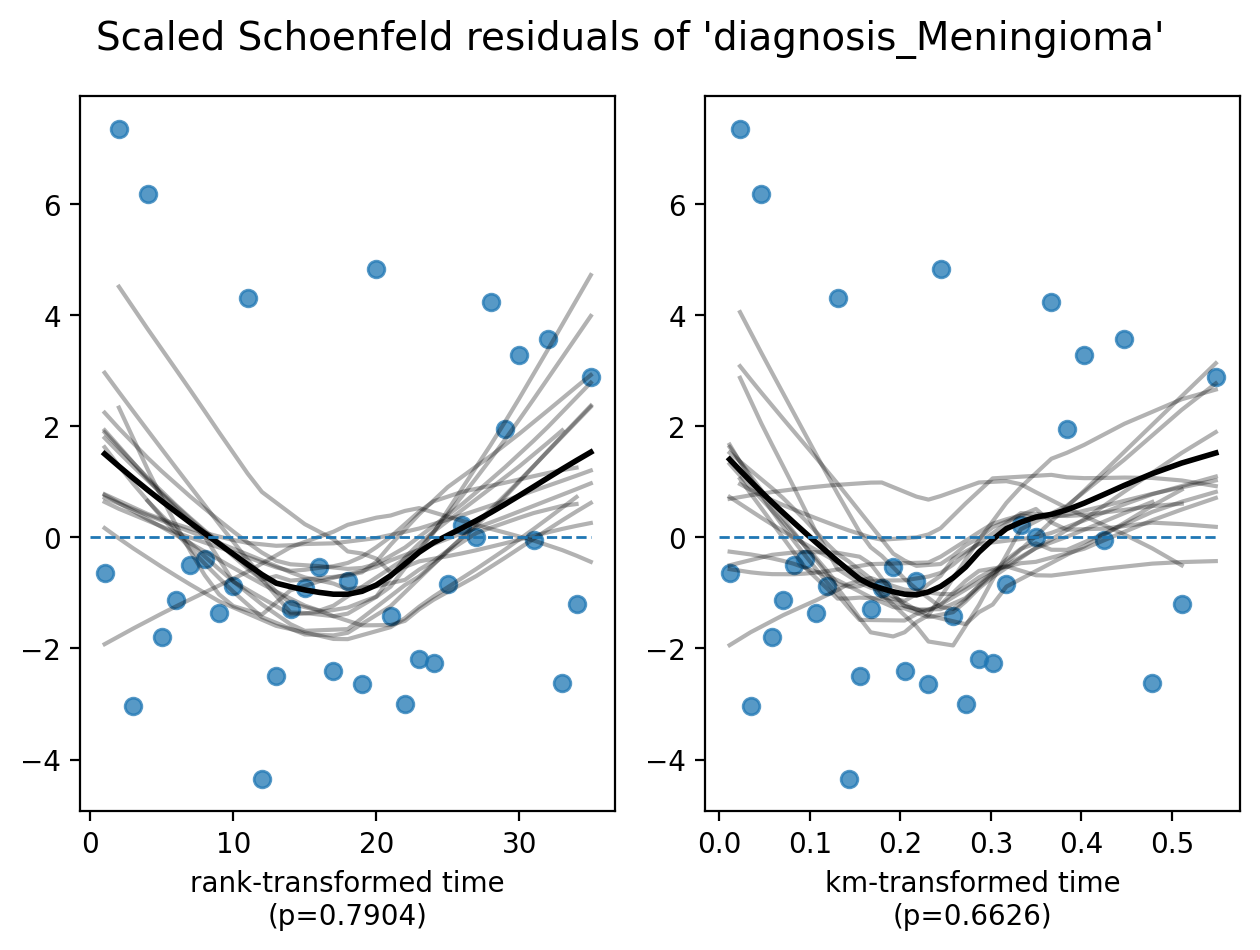

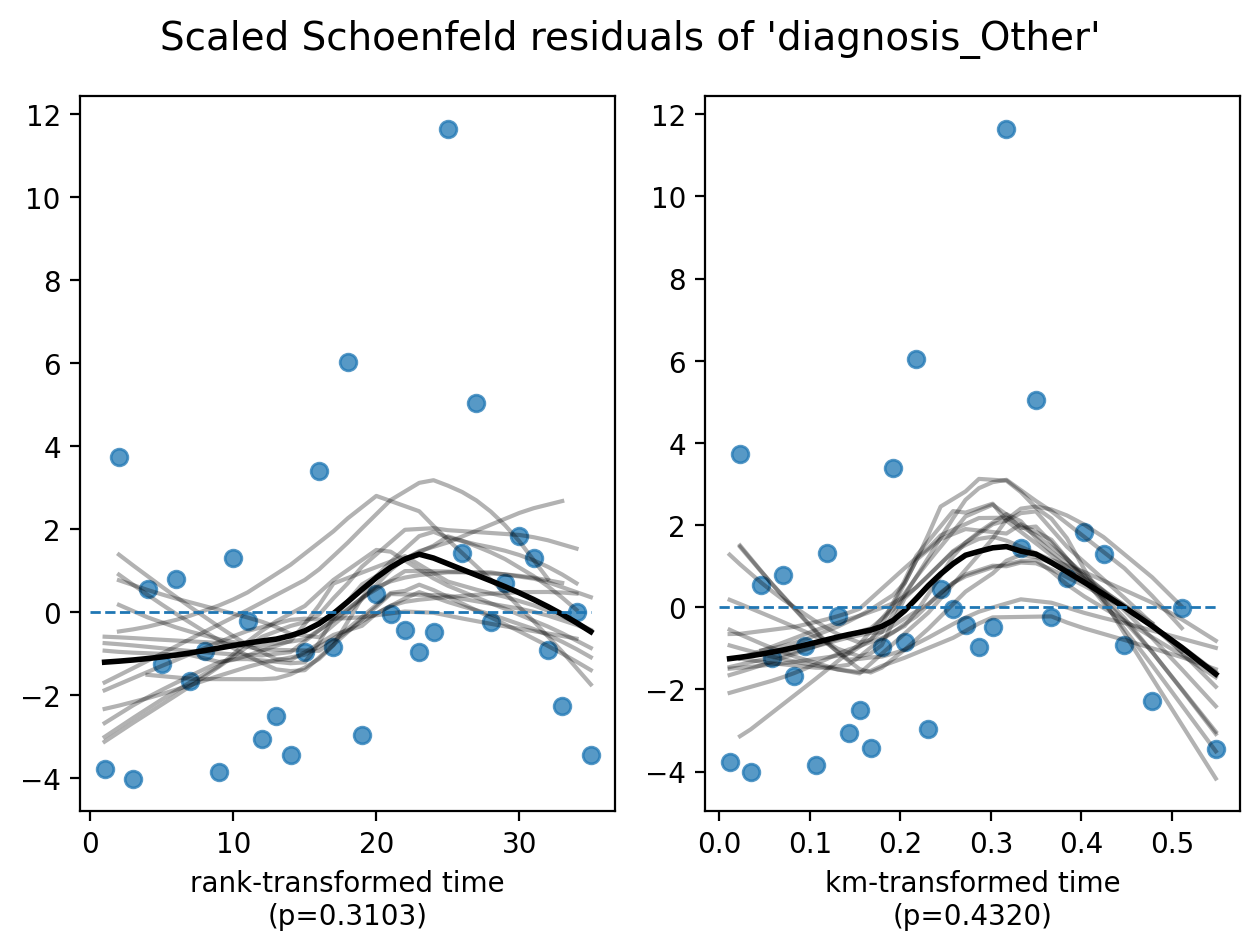

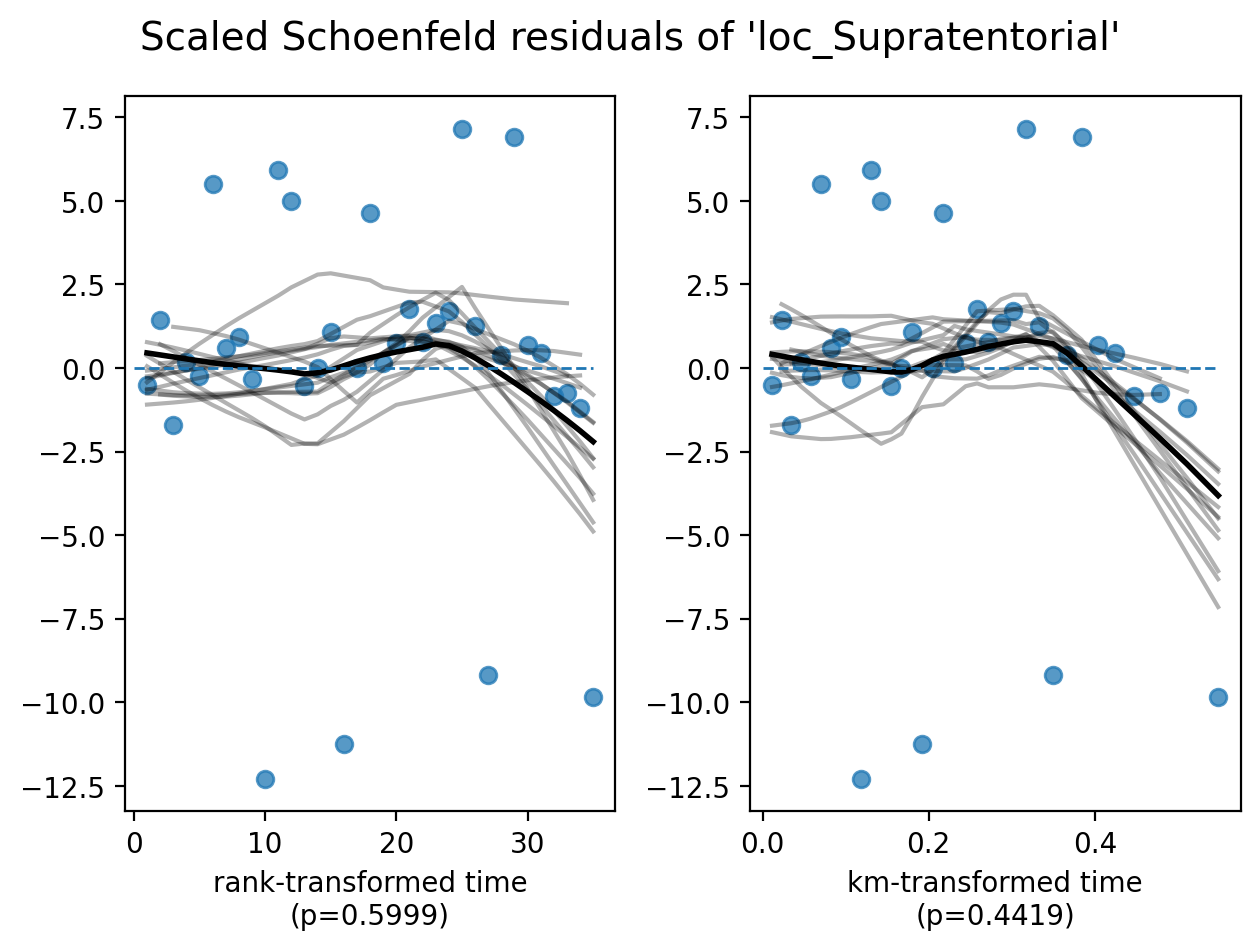

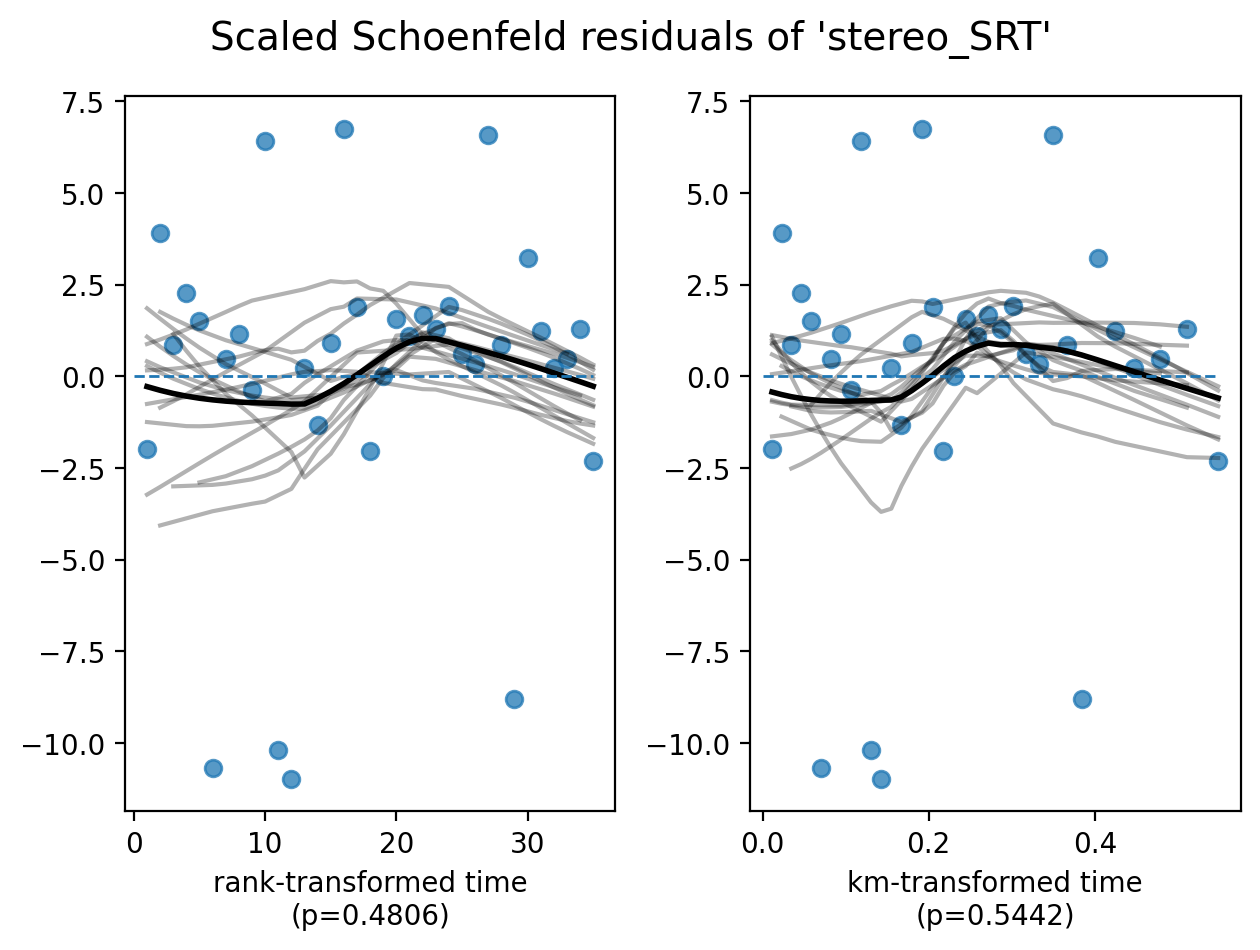

In [7]:
cph.check_assumptions(brain_scaled, p_value_threshold=0.05, show_plots=True)

Alternatively, you can use the proportional hazard test outside of `check_assumptions`:

In [8]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, brain_scaled, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
diagnosis_LG glioma             0.45 0.50      0.99
diagnosis_Meningioma            0.07 0.79      0.34
diagnosis_Other                 1.03 0.31      1.69
gtv                             0.47 0.49      1.02
ki                              0.11 0.74      0.44
loc_Supratentorial              0.28 0.60      0.74
sex_Male                        1.04 0.31      1.70
stereo_SRT                      0.50 0.48      1.06

#### Stratification


In the advice above, we can see that `wexp` has small cardinality, so we can easily fix that by specifying it in the `strata`. What does the `strata` do? Let's go back to the proportional hazard assumption.

In the introduction, we said that the proportional hazard assumption was that 

$$ h_i(t) = a_i h(t)$$

In a simple case, it may be that there are two subgroups that have _very_ different baseline hazards. That is, we can split the dataset into subsamples based on some variable (we call this the stratifying variable), run the Cox model on all subsamples, and compare their baseline hazards. If these baseline hazards are _very_ different, then clearly the formula above is wrong - the $h(t)$ is some weighted average of the subgroups' baseline hazards. This ill fitting average baseline can cause $a_i$ to have time-dependent influence. A better model might be:

$$ h_{i |i\in G}(t) = a_i h_G(t)$$

where now we have a unique baseline hazard _per_ subgroup $G$. Because of the way the Cox model is designed, inference of the coefficients is identical (expect now there are more baseline hazards, and no variation of the stratifying variable within a subgroup $G$). 


In [6]:
cph.fit(rossi, 'week', 'arrest', strata=['wexp'])
cph.print_summary(model="wexp in strata")

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = ['wexp']
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -580.89
         time fit was run = 2020-07-26 22:15:41 UTC
                    model = wexp in strata

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.76            -0.01                 0.47                 0.99
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.36       0.31            -0.30             0.91                 0.74                 2.49
mar        -0.45       0.64       0.38            -1.20             0.29                 0.30                 1.34
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.09       0.03             0.03             0.15                 1.04                 1.16
              z      p   -log2(p)
covariate                        
fin       -1.99   0.05       4.42
age       -2.64   0.01       6.91
race       1.00   0.32       1.65
mar       -1.19   0.23       2.09
paro      -0.42   0.67       0.57
prio       3.16 <0.005       9.33
---
Concordance = 0.61
Partial AIC = 1173.77
log-likelihood ratio test = 23.77 on 6 df
-log2(p) of ll-ratio test = 10.77

In [11]:
cph.check_assumptions(brain_scaled, show_plots=True)

Proportional hazard assumption looks okay.


c:\Users\rserr\anaconda3\envs\ds_py38\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

Since `age` is still violating the proportional hazard assumption, we need to model it better.  From the residual plots above, we can see a the effect of age start to become negative over time. This will be relevant later. Below, we present three options to handle `age`. 

#### Modify the functional form

The proportional hazard test is very sensitive (i.e. lots of false positives) when the functional form of a variable is incorrect. For example, if the association between a covariate and the log-hazard is non-linear, but the model has only a linear term included, then the proportional hazard test can raise a false positive. 

The modeller can choose to add quadratic or cubic terms, i.e:
```
rossi['age**2'] = (rossi['age'] - rossi['age'].mean())**2
rossi['age**3'] = (rossi['age'] - rossi['age'].mean())**3
```

but I think a more correct way to include non-linear terms is to use basis splines:

In [9]:
cph.fit(rossi, 'week', 'arrest', strata=['wexp'], formula="bs(age, df=4, lower_bound=10, upper_bound=50) + fin +race + mar + paro + prio")
cph.print_summary(model="spline_model"); print()
cph.check_assumptions(rossi, show_plots=True, p_value_threshold=0.05)

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = ['wexp']
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -579.36
         time fit was run = 2020-07-26 22:19:25 UTC
                    model = spline_model

---
                                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                
bs(age, df=4, lower_bound=10, upper_bound=50)[0]  -2.95       0.05       8.32           -19.26            13.37                 0.00             6.39e+05
bs(age, df=4, lower_bound=10, upper_bound=50)[1]  -5.48       0.00       6.23           -17.69             6.73                 0.00               839.48
bs(age, df=4, lower_bound=10, upper_bound=50)[2]  -3.69       0.03       8.88           -21.10            13.72                 0.00             9.09e+05
bs(age, df=4, lower_bound=10, upper_bound=50)[3]  -6.02       0.00       6.75           -19.26             7.21                 0.00              1351.35
fin                                               -0.37       0.69       0.19            -0.75             0.01                 0.47                 1.01
race                                               0.35       1.42       0.31            -0.26             0.95                 0.77                 2.60
mar                                               -0.39       0.67       0.38            -1.15             0.36                 0.32                 1.43
paro                                              -0.10       0.90       0.20            -0.49             0.28                 0.61                 1.33
prio                                               0.09       1.10       0.03             0.04             0.15                 1.04                 1.16
                                                     z      p   -log2(p)
covariate                                                               
bs(age, df=4, lower_bound=10, upper_bound=50)[0] -0.35   0.72       0.47
bs(age, df=4, lower_bound=10, upper_bound=50)[1] -0.88   0.38       1.40
bs(age, df=4, lower_bound=10, upper_bound=50)[2] -0.42   0.68       0.56
bs(age, df=4, lower_bound=10, upper_bound=50)[3] -0.89   0.37       1.43
fin                                              -1.93   0.05       4.22
race                                              1.13   0.26       1.95
mar                                              -1.02   0.31       1.71
paro                                             -0.53   0.60       0.75
prio                                              3.22 <0.005       9.59
---
Concordance = 0.62
Partial AIC = 1176.72
log-likelihood ratio test = 26.82 on 9 df
-log2(p) of ll-ratio test = 9.38


Proportional hazard assumption looks okay.


We see may still have potentially _some_ violation, but it's a heck of a lot less. Also, interestingly, when we include these non-linear terms for `age`, the `wexp` proportionality violation disappears. It is not uncommon to see changing the functional form of one variable effects other's proportional tests, usually positively. So, we could remove the `strata=['wexp']` if we wished. 

#### Bin variable and stratify on it


The second option proposed is to bin the variable into equal-sized bins, and stratify like we did with `wexp`. There is a trade off here between estimation and information-loss. If we have large bins, we will lose information (since different values are now binned together), but we need to estimate less new baseline hazards. On the other hand, with tiny bins, we allow the `age` data to have the most "wiggle room", but must compute many baseline hazards each of which has a smaller sample size. Like most things, the optimial value is somewhere inbetween.

In [10]:
rossi_strata_age = rossi.copy()
rossi_strata_age['age_strata'] = pd.cut(rossi_strata_age['age'], np.arange(0, 80, 3))

rossi_strata_age[['age', 'age_strata']].head()

,age,age_strata
0,27,"(24, 27]"
1,18,"(15, 18]"
2,19,"(18, 21]"
3,23,"(21, 24]"
4,19,"(18, 21]"


In [11]:
# drop the orignal, redundant, age column
rossi_strata_age = rossi_strata_age.drop('age', axis=1)
cph.fit(rossi_strata_age, 'week', 'arrest', strata=['age_strata', 'wexp'])

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = ['age_strata', 'wexp']
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -392.443
         time fit was run = 2020-07-26 22:19:46 UTC
                    model = stratified age and wexp

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin       -0.395      0.674      0.197           -0.781           -0.009                0.458                0.991
race       0.280      1.324      0.313           -0.334            0.895                0.716                2.447
mar       -0.194      0.824      0.392           -0.961            0.574                0.382                1.776
paro      -0.163      0.849      0.200           -0.555            0.228                0.574                1.256
prio       0.080      1.084      0.028            0.025            0.135                1.025                1.145
               z     p   -log2(p)
covariate                        
fin       -2.004 0.045      4.472
race       0.895 0.371      1.431
mar       -0.494 0.621      0.687
paro      -0.818 0.413      1.275
prio       2.854 0.004      7.857
---
Concordance = 0.582
Partial AIC = 794.887
log-likelihood ratio test = 13.247 on 5 df
-log2(p) of ll-ratio test = 5.562

<AxesSubplot:xlabel='log(HR) (95% CI)'>

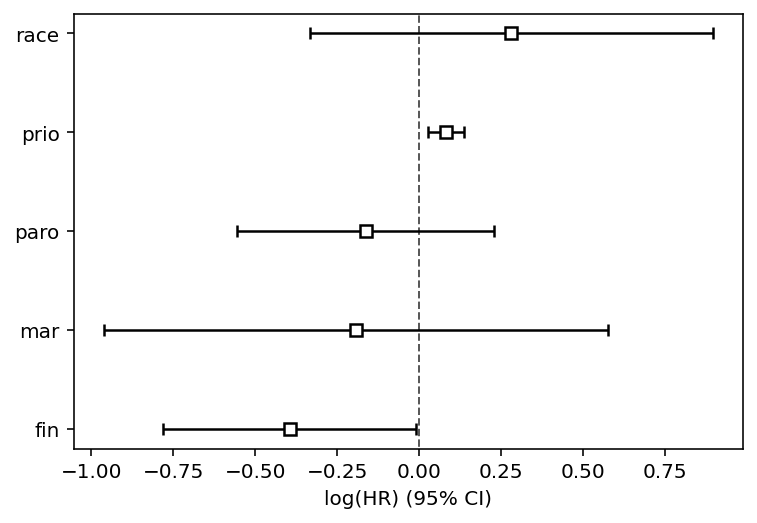

In [12]:
cph.print_summary(3, model="stratified age and wexp")
cph.plot()

In [13]:
cph.check_assumptions(rossi_strata_age)

Proportional hazard assumption looks okay.


#### Introduce time-varying covariates

Our second option to correct variables that violate the proportional hazard assumption is to model the time-varying component directly. This is done in two steps. The first is to transform your dataset into _episodic format_. This means that we split a subject from a single row into $n$ new rows, and each new row represents some time period for the subject. It's okay that the variables are static over this new time periods - we'll introduce some time-varying covariates later.

See below for how to do this in _lifelines_:

In [14]:
from lifelines.utils import to_episodic_format

# the time_gaps parameter specifies how large or small you want the periods to be. 
rossi_long = to_episodic_format(rossi, duration_col='week', event_col='arrest', time_gaps=1.)
rossi_long.head(25)


,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
0,1.0,0.0,0,27,0,0,0,1,3,1,0
1,2.0,1.0,0,27,0,0,0,1,3,1,0
2,3.0,2.0,0,27,0,0,0,1,3,1,0
3,4.0,3.0,0,27,0,0,0,1,3,1,0
4,5.0,4.0,0,27,0,0,0,1,3,1,0
5,6.0,5.0,0,27,0,0,0,1,3,1,0
6,7.0,6.0,0,27,0,0,0,1,3,1,0
7,8.0,7.0,0,27,0,0,0,1,3,1,0
8,9.0,8.0,0,27,0,0,0,1,3,1,0
9,10.0,9.0,0,27,0,0,0,1,3,1,0


Each subject is given a new id (but can be specified as well if already provided in the dataframe). This id is used to track subjects over time. Notice the `arrest` col is 0 for all periods prior to their (possible) event as well. 

Above I mentioned there were two steps to correct `age`. The first was to convert to a episodic format. The second is to create an interaction term between `age` and `stop`. This is a time-varying variable.

Instead of `CoxPHFitter`, we must use `CoxTimeVaryingFitter` instead since we are working with a episodic dataset. 

In [15]:
rossi_long['time*age'] = rossi_long['age'] * rossi_long['stop']

In [16]:
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

ctv.fit(rossi_long, 
        id_col='id', 
        event_col='arrest', 
        start_col='start', 
        stop_col='stop', 
        strata=['wexp'])

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>

In [17]:
ctv.print_summary(3, model="age * time interaction")

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
 number of periods = 19809
  number of events = 114
partial log-likelihood = -575.080
  time fit was run = 2020-07-26 22:19:49 UTC
             model = age * time interaction

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age        0.073      1.075      0.040           -0.005            0.151                0.995                1.163
fin       -0.386      0.680      0.191           -0.760           -0.011                0.468                0.989
mar       -0.397      0.672      0.382           -1.147            0.352                0.318                1.422
paro      -0.098      0.907      0.196           -0.481            0.285                0.618                1.330
prio       0.090      1.094      0.029            0.034            0.146                1.035                1.158
race       0.295      1.343      0.308           -0.310            0.899                0.733                2.458
time*age  -0.005      0.995      0.002           -0.008           -0.002                0.992                0.998
               z     p   -log2(p)
covariate                        
age        1.830 0.067      3.893
fin       -2.018 0.044      4.520
mar       -1.039 0.299      1.743
paro      -0.501 0.616      0.698
prio       3.152 0.002      9.267
race       0.955 0.340      1.558
time*age  -3.337 0.001     10.203
---
Partial AIC = 1164.160
log-likelihood ratio test = 35.386 on 7 df
-log2(p) of ll-ratio test = 16.689

In [ ]:
ctv.plot()

<AxesSubplot:xlabel='log(HR) (95% CI)'>

In the above scaled Schoenfeld residual plots for `age`, we can see there is a slight negative effect for higher time values. This is confirmed in the output of the `CoxTimeVaryingFitter`: we see that the coefficient for `time*age` is -0.005.

#### Conclusion

The point estimates and the standard errors are very close to each other using either option, we can feel confident that either approach is okay to proceed. 

## Do I need to care about the proportional hazard assumption?

You may be surprised that often you don't need to care about the proportional hazard assumption. There are many reasons why not:

1. If your goal is survival prediction, then you don't need to care about proportional hazards. Your goal is to maximize some score, irrelevant of how predictions are generated. 

2. Given a large enough sample size, even very small violations of proportional hazards will show up.  

3. There are legitimate reasons to assume that all datasets will violate the proportional hazards assumption. This is detailed well in Stensrud & Hernán's "Why Test for Proportional Hazards?" [1]. 

4. “Even if the hazards were not proportional, altering the model to fit a set of assumptions fundamentally changes the scientific question. As Tukey said,”Better an approximate answer to the exact question, rather than an exact answer to the approximate question.” If you were to fit the Cox model in the presence of non-proportional hazards, what is the net effect? Slightly less power. In fact, you can recover most of that power with robust standard errors (specify robust=True). In this case the interpretation of the (exponentiated) model coefficient is a time-weighted average of the hazard ratio–I do this every single time.” from AdamO, slightly modified to fit lifelines [2]

Given the above considerations, the status quo is still to check for proportional hazards. So if you are avoiding testing for proportional hazards, be sure to understand and able to answer _why_ you are avoiding testing. 


1.  Stensrud MJ, Hernán MA. Why Test for Proportional Hazards? JAMA. Published online March 13, 2020. doi:10.1001/jama.2020.1267
2. AdamO (https://stats.stackexchange.com/users/8013/adamo), Checking the proportional hazard assumption, URL (version: 2019-04-05): https://stats.stackexchange.com/q/400981